In [1]:
# Brian Chan
# June 2021

%matplotlib notebook

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Convert data in wikipedia articles to csv files.

argonauts_dfs = pd.read_html('https://en.wikipedia.org/wiki/List_of_Toronto_Argonauts_seasons')
argonauts_df = argonauts_dfs[1]
argonauts_df.to_csv('argonauts.csv')
argonauts = pd.read_csv('argonauts.csv', header=None)

maple_leafs_dfs = pd.read_html('https://en.wikipedia.org/wiki/List_of_Toronto_Maple_Leafs_seasons')
maple_leafs_df = maple_leafs_dfs[2]
maple_leafs_df.to_csv('maple_leafs.csv')
maple_leafs = pd.read_csv('maple_leafs.csv', header=None)

In [3]:
# Functions to help clean and wrangle the data.

def mark_section_rows(year_str):
    if year_str[:2] != '19' and year_str[:2] != '20':
        return 'remove'
    return year_str

def mark_cancellations(num_str):
    if 'lockout' in num_str or 'suspended' in num_str or 'dispute' in num_str or 'No regular' in num_str:
        return np.nan
    return num_str

def mark_unfilled(entry_str):
    digits = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    if entry_str[0] not in digits:
        return '0'
    return entry_str

def remove_citations(entry_str):
    digits = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    if entry_str[-1] == ']':
        return entry_str[:-3]
    return entry_str

In [4]:
# Extract data from csv files and clean the data.

# For the maple leafs, I added .5 to the years because the table for the Toronto 
# Maple Leafs include ranges between years. So 1917-1918 is replaced with 1917.5, 
# 1918-1919 is replaced with 1918.5 and so on.

argonauts = argonauts.iloc[:, [2, 6, 7, 8]].iloc[1:-4]
argonauts.rename(columns = {2 : 'Year', 6 : 'Wins', 7 : 'Losses', 8 : 'Ties'}, inplace=True)

argonauts['Wins'] = argonauts['Wins'].apply(mark_cancellations)
argonauts['Losses'] = argonauts['Losses'].apply(mark_cancellations)
argonauts['Ties'] = argonauts['Ties'].apply(mark_cancellations)

argonauts['Year'] = pd.to_numeric(argonauts['Year'])
argonauts['Wins'] = pd.to_numeric(argonauts['Wins'])
argonauts['Losses'] = pd.to_numeric(argonauts['Losses'])
argonauts['Ties'] = pd.to_numeric(argonauts['Ties'])


maple_leafs = maple_leafs.iloc[:, [2, 6, 7, 9, 10]].iloc[3:-1]
maple_leafs.rename(columns={2 : 'Year', 6 : 'Games', 7 : 'Wins', 
                            9 : 'Ties', 10 : 'Overtime_losses'}, inplace=True)

maple_leafs['Year'] = maple_leafs['Year'].apply(mark_section_rows)
maple_leafs = maple_leafs[maple_leafs['Year'] != 'remove']

maple_leafs['Ties'] = maple_leafs['Ties'].apply(remove_citations)
maple_leafs['Ties'] = maple_leafs['Ties'].apply(mark_unfilled)
maple_leafs['Overtime_losses'] = maple_leafs['Overtime_losses'].apply(remove_citations)
maple_leafs['Overtime_losses'] = maple_leafs['Overtime_losses'].apply(mark_unfilled)

maple_leafs['Games'] = maple_leafs['Games'].apply(mark_cancellations)
maple_leafs['Wins'] = maple_leafs['Wins'].apply(mark_cancellations)

maple_leafs['Year'] = pd.to_numeric(maple_leafs['Year'].apply(lambda x : x[:4])).apply(lambda x : x + 0.5)
maple_leafs['Games'] = pd.to_numeric(maple_leafs['Games'])
maple_leafs['Wins'] = pd.to_numeric(maple_leafs['Wins'])
maple_leafs['Ties'] = pd.to_numeric(maple_leafs['Ties'])
maple_leafs['Overtime_losses'] = pd.to_numeric(maple_leafs['Overtime_losses'])

In [5]:
# Calculate the Win %.

maple_leafs = maple_leafs.groupby('Year').sum()
maple_leafs['Win %'] = 100 * (2 * maple_leafs['Wins'] + maple_leafs['Ties'] + maple_leafs['Overtime_losses']) / (2 * maple_leafs['Games'])
maple_leafs.drop(columns=['Games', 'Wins', 'Ties', 'Overtime_losses'], inplace=True)

argonauts['Win %'] = 100 * (argonauts['Wins'] + 0.5 * argonauts['Ties']) / (argonauts['Wins'] + argonauts['Ties'] + argonauts['Losses'])
argonauts.drop(columns=['Wins', 'Losses', 'Ties'], inplace=True)
argonauts.set_index('Year', inplace=True)

<IPython.core.display.Javascript object>


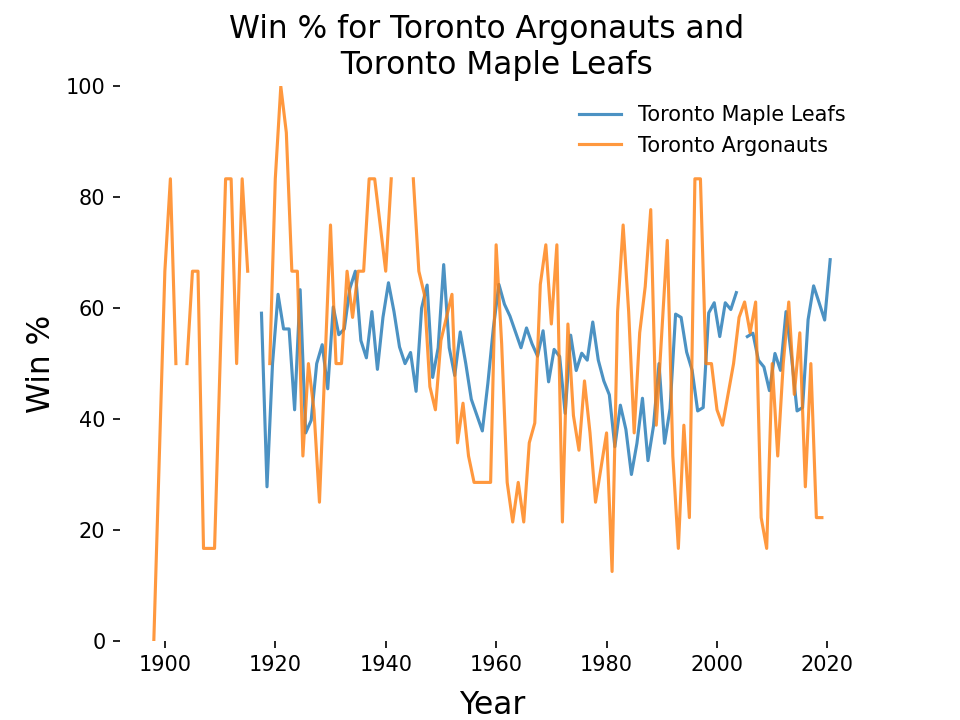

In [6]:
# Present results as a graph.

plt.plot(maple_leafs.index, maple_leafs['Win %'], label='Toronto Maple Leafs', alpha=0.8)
plt.plot(argonauts.index, argonauts['Win %'], label='Toronto Argonauts', alpha=0.8)

plt.box(False)
plt.legend(frameon=False)
plt.ylabel('Win %', size=15)
plt.xlabel('Year', size=15, labelpad=7)
plt.title('Win % for Toronto Argonauts and \n Toronto Maple Leafs', size=15)
plt.ylim(0,100)
plt.savefig('Win % Data.jpg')